<a href="https://colab.research.google.com/gist/Justinezgh/75ee6fbd05c999f81b2d18d61f4fc308/tuto_npe_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet sbibm dm-haiku
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/sbi_lens.git
!pip install --quiet chainconsumer==0.34.0

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.3.2 which is incompatible.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.3.2 which is incompatible.


In [1]:
import sbibm
import jax
import jax.numpy as jnp
import sbi_lens
from functools import partial
import haiku as hk
import optax

jax.config.update("jax_enable_x64", True)

# Simulation model

In [2]:
# you can choose any simulation model
sbibm.get_available_tasks()

['bernoulli_glm',
 'gaussian_linear',
 'gaussian_linear_uniform',
 'gaussian_mixture',
 'lotka_volterra',
 'sir',
 'slcp',
 'two_moons',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [3]:
task = sbibm.get_task("gaussian_mixture")
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim = truth.shape[0] # the dimensionality of the params space

2024-02-01 09:07:23.458640: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Neural Posterior Estimation

In [4]:
# Create neural density estimator (NDE) to approximate p(theta | y)
from sbi_lens.normflow.models import AffineCoupling, ConditionalRealNVP

# Affine bijection used in the RealNVP coupling
bijector_npe = partial(
  AffineCoupling,
  layers=[128] * 2,
  activation=jax.nn.silu
)

# Normalizing Flow with 4 RealNVP coupling layers
NF_npe = partial(
  ConditionalRealNVP,
  n_layers=4,
  bijector_fn=bijector_npe
)


# log probability of the NDE
nvp_nd = hk.without_apply_rng(
    hk.transform(
        lambda theta,y : NF_npe(dim)(y).log_prob(theta).squeeze()
    )
)

# sampling of the NDE
nvp_sample_nd = hk.transform(
  lambda y : NF_npe(dim)(y).sample(100_000, seed=hk.next_rng_key())
)

2024-02-01 09:07:25.824309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 09:07:25.824373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 09:07:25.825266: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 09:07:27.889924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# negative log likelihood
def loss_nll(params, mu, batch):
    return - jnp.mean(nvp_nd.apply(params, mu, batch))

@jax.jit
def update(params, opt_state, mu, batch):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_nll)(
        params,
        mu,
        batch,
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [6]:
# init nf params
params = nvp_nd.init(
    jax.random.PRNGKey(42),
    0.5 * jnp.ones([1, dim]),
    0.5 * jnp.ones([1, dim])
)

# define optimizer
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)

In [7]:
# training
from tqdm import tqdm

batch_size = 128
batch_loss = []
pbar = tqdm(range(5_000))

for batch in pbar:
  thetas = prior(num_samples=batch_size)
  xs = simulator(thetas)

  l, params, opt_state = update(
      params,
      opt_state,
      jnp.array(thetas, dtype=jnp.float64),
      jnp.array(xs, dtype=jnp.float64),
  )
  batch_loss.append(l)
  pbar.set_description(f"loss {l:.3f}")

loss nan: 100%|██████████| 5000/5000 [00:17<00:00, 286.24it/s]         


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


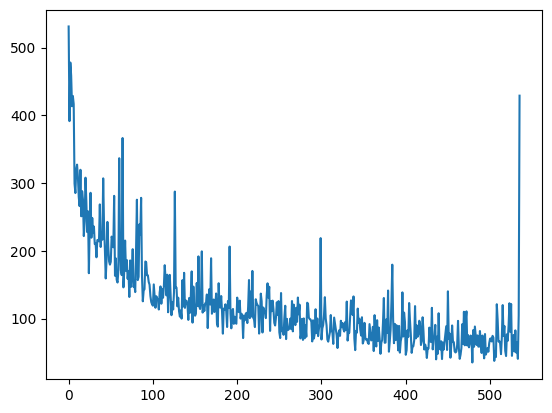

In [8]:
%pylab inline
plt.plot(batch_loss[50:])

# Results

In [9]:
from chainconsumer import ChainConsumer

# plot infered params
sample_nd = nvp_sample_nd.apply(
      params,
      rng = jax.random.PRNGKey(43),
      y = observation * jnp.ones([100_000, dim])
)

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(sample_nd,  shade_alpha = 0.5, name='Prediction')
fig = c.plotter.plot(figsize=1.)

AssertionError: Data for chain Prediction, parameter 0 is being used, but has either NaNs or infs in it!

In [10]:
sample_nd.shape

(100000, 2)